In [2]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform, OrderedTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
import jax
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random, lax
from jax import nn as jnn
from jax.scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [3]:
d = pd.read_csv('data/Trolley.csv', sep=';')

In [4]:
d.sample(5)

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
9509,nfrub,4,26,98;087,45,0,Some College,1,0,0,rub,1
3660,cfaqu,6,2,97;145,27,1,Some College,0,0,1,aqu,1
8404,cibur,4,29,97;871,39,1,Bachelor's Degree,0,1,1,bur,1
6349,ikbur,2,20,97;622,67,1,Graduate Degree,1,1,0,bur,1
6388,ilswi,6,18,97;624,44,1,Bachelor's Degree,0,1,0,swi,0


<AxesSubplot:>

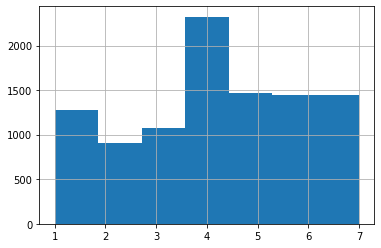

In [5]:
d['response'].hist(bins=7)

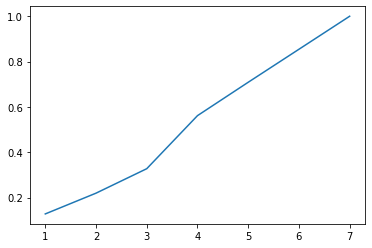

In [6]:
cum_prob = d['response'].value_counts().sort_index().cumsum() / d['response'].count()
plt.plot(cum_prob)

cutpoint values:  1   -1.916091
2   -1.266606
3   -0.718634
4    0.247786
5    0.889864
6    1.769381
7         inf
Name: response, dtype: float64


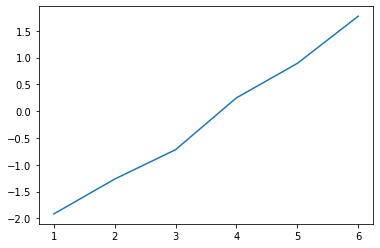

In [10]:
ak = np.log(cum_prob/(1-cum_prob))
print('cutpoint values: ',ak)
plt.plot(ak)

In [8]:
def model(y):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(0, 1.5).expand([6]), OrderedTransform()
        ),
    )
    response = numpyro.sample('response', dist.OrderedLogistic(0, cutpoints), obs=y)

In [9]:
m12_4 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m12_4.run(random.PRNGKey(0), y=d.response.values - 1)
m12_4.print_summary()

sample: 100%|██████████| 1000/1000 [00:03<00:00, 304.42it/s, 3 steps of size 4.05e-01. acc. prob=0.93]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
cutpoints[0]     -1.92      0.03     -1.92     -1.97     -1.86    383.46      1.00
cutpoints[1]     -1.27      0.02     -1.27     -1.30     -1.22    490.99      1.00
cutpoints[2]     -0.72      0.02     -0.72     -0.76     -0.69    454.52      1.00
cutpoints[3]      0.25      0.02      0.25      0.22      0.28    510.31      1.00
cutpoints[4]      0.89      0.02      0.89      0.86      0.93    517.06      1.00
cutpoints[5]      1.77      0.03      1.77      1.73      1.82    585.34      1.00

Number of divergences: 0


In [11]:
post = m12_4.get_samples()

In [16]:
cp_mean = post['cutpoints'].mean(axis=0)
cum_prob = expit(cp_mean)

In [17]:
cum_prob

DeviceArray([0.1283588 , 0.22004355, 0.32802457, 0.56201154, 0.70925593,
             0.85450315], dtype=float32)

In [18]:
d.groupby(['action', 'intention', 'contact']).size().loc[lambda x: x>0].sort_values(ascending=False)

action  intention  contact
1       0          0          2648
0       1          0          1986
        0          0          1655
1       1          0          1655
0       0          1           993
        1          1           993
dtype: int64

In [21]:
def model(a, c, i, y):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(0, 1.5).expand([6]), OrderedTransform()
        ),
    )
    b_a = numpyro.sample("b_a", dist.Normal(0, 1.5))
    b_c = numpyro.sample("b_c", dist.Normal(0, 1.5))
    b_i = numpyro.sample("b_i", dist.Normal(0, 1.5))
    b_ai = numpyro.sample("b_ai", dist.Normal(0, 1.5))
    b_ci = numpyro.sample("b_ci", dist.Normal(0, 1.5))
    beta = b_i + b_ai*a + b_ci*c
    phi = b_a*a + b_c*c +beta*i
    response = numpyro.sample('response', dist.OrderedLogistic(phi, cutpoints), obs=y)
m12_5 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m12_5.run(random.PRNGKey(0), a=d.action.values, c=d.contact.values, i=d.intention.values, y=d.response.values - 1)
m12_5.print_summary()

sample: 100%|██████████| 1000/1000 [00:18<00:00, 52.78it/s, 15 steps of size 2.43e-01. acc. prob=0.92]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         b_a     -0.47      0.06     -0.47     -0.56     -0.38    225.74      1.00
        b_ai     -0.45      0.08     -0.45     -0.58     -0.32    240.70      1.00
         b_c     -0.33      0.07     -0.33     -0.44     -0.21    271.40      1.00
        b_ci     -1.27      0.10     -1.27     -1.41     -1.10    368.00      1.00
         b_i     -0.28      0.06     -0.28     -0.39     -0.19    253.10      1.00
cutpoints[0]     -2.63      0.05     -2.63     -2.72     -2.55    250.92      1.00
cutpoints[1]     -1.94      0.05     -1.93     -2.01     -1.86    240.02      1.00
cutpoints[2]     -1.34      0.05     -1.34     -1.43     -1.28    248.64      1.00
cutpoints[3]     -0.31      0.05     -0.31     -0.39     -0.24    263.76      1.00
cutpoints[4]      0.36      0.05      0.36      0.29      0.44    279.61      1.00
cutpoints[5]      1.27      0.05      1.27      1.20      1.36    325.27      1.00

Nu

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

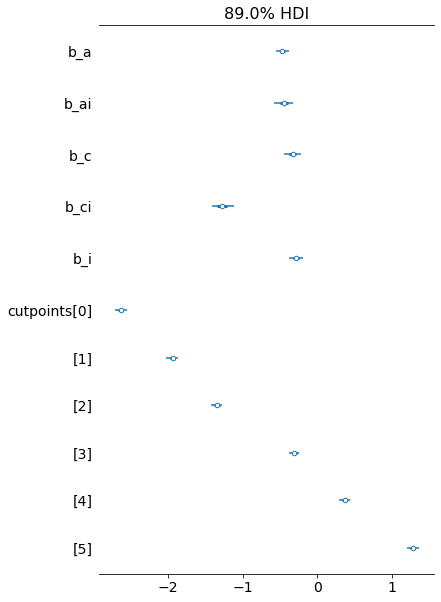

In [26]:
az12_5 = az.from_numpyro(m12_5)
az.plot_forest(az12_5, hdi_prob=0.89)

In [40]:
dir_samp = dist.Dirichlet(jnp.repeat(2,7)).expand([10,]).sample(random.PRNGKey(0))

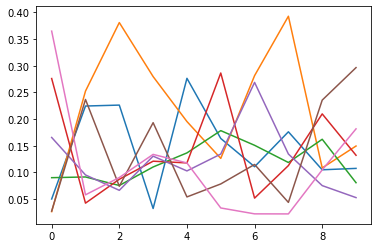

In [41]:
plt.plot(dir_samp)

In [42]:
d.edu.unique()

array(['Middle School', "Bachelor's Degree", 'Some College',
       "Master's Degree", 'High School Graduate', 'Graduate Degree',
       'Some High School', 'Elementary School'], dtype=object)

In [44]:
d['e'] = d.edu.map({'Middle School':1, "Bachelor's Degree":5, 'Some College':4,
       "Master's Degree":6, 'High School Graduate':3, 'Graduate Degree':7,
       'Some High School':2, 'Elementary School':0})

In [58]:
def model(a, c, i, e, y):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(0, 1.5).expand([7]), OrderedTransform()
        ),
    )
    b_a = numpyro.sample("b_a", dist.Normal(0, 1))
    b_c = numpyro.sample("b_c", dist.Normal(0, 1))
    b_i = numpyro.sample("b_i", dist.Normal(0, 1))
    b_e = numpyro.sample("b_e", dist.Normal(0, 1))
    delta_j = numpyro.sample("delta_j", dist.Dirichlet(jnp.repeat(2,7)))
    delta_j = jnp.concatenate((jnp.array([0,]), delta_j))
    delta_e = jnp.sum(jnp.where(jnp.arange(8) <= e[..., None], delta_j, 0), -1)
    phi = b_a*a + b_c*c + b_i*i + b_e*delta_e

    response = numpyro.sample('response', dist.OrderedLogistic(phi, cutpoints), obs=y)

m12_5 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m12_5.run(random.PRNGKey(0), a=d.action.values, c=d.contact.values, i=d.intention.values, e=d.e.values, y=d.response.values - 1)
m12_5.print_summary()

sample: 100%|██████████| 1000/1000 [01:32<00:00, 10.85it/s, 31 steps of size 9.44e-02. acc. prob=0.89]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         b_a     -0.71      0.04     -0.71     -0.77     -0.64    247.93      1.00
         b_c     -0.96      0.05     -0.96     -1.04     -0.89    160.64      1.00
         b_e     -0.35      0.17     -0.33     -0.61     -0.07    105.92      1.00
         b_i     -0.72      0.04     -0.72     -0.78     -0.66    292.15      1.00
cutpoints[0]     -3.12      0.16     -3.10     -3.34     -2.84    119.55      1.00
cutpoints[1]     -2.43      0.16     -2.42     -2.69     -2.20    118.65      1.00
cutpoints[2]     -1.85      0.15     -1.83     -2.12     -1.64    117.78      1.00
cutpoints[3]     -0.83      0.15     -0.80     -1.09     -0.60    118.93      1.00
cutpoints[4]     -0.16      0.15     -0.14     -0.41      0.08    121.41      1.00
cutpoints[5]      0.75      0.15      0.77      0.53      1.00    119.11      1.00
cutpoints[6]     10.69      1.88     10.61      7.70     13.95    132.85      1.00
  d

In [51]:
delta_j = jnp.array([0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.3])
e=d.e.values
e[..., None].shape


(9930, 1)

In [55]:
delta_e = jnp.sum(jnp.where(jnp.arange(8) <= e[..., None], delta_j, 0), -1)

In [56]:
delta_e.shape

(9930,)